## Clustering about Gaussian Mixture Model

Latent variable을 이용한 gaussian mixture model이 어떻게 구성되는지를 코드를 통해 구성해보자 합니다. 이는 문일철교수님의 강의 인공지능 및 기계학습 2를 참고 했음을 밝힙니다.

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Gaussian Mixture model

$$
P_X(x) =\sum_{k=1}^{K}\pi_k N(x\space|\space\mu_i, \Sigma_i)
$$

- Multinomial distribution (Latent variable이 어떤 분포를 따라는가?)
    - $\pi$ : mixing coefficient
    

- Multivariable Gaussian Distribution (Latent Variable이 결정되었을때, 하나의 클러스터 안에서 데이터가 어떤 분포를 따르는가?)
    - $N(x\space|\space\mu_i, \Sigma_i)$ : Gaussian Distribution (about sub population)

### Optimal points!

In [2]:
# pi_true: mixing coefficient 의 값이 된다.
# mu_true : sub population의 평균값, 다양한 차원으로 존재하기 때문에 matrix 형태이다.
# sigma_true: sub population의 공분산, 다양한 차원으로 존재하기 때문에 역시 matrix형태이다.

pi_true = np.array([0.35, 0.45, 0.2])
mu_true = np.array([[-1, 3], [1, 5], [3,7]])

sigma_true = np.zeros((3, 2, 2))

sigma_true[0] = np.array([[0.9, 0.1], [0.1, 0.9]])/3
sigma_true[1] = np.array([[0.6, 0.4], [0.4, 0.6]])/3
sigma_true[2] = np.array([[0.7, 0.3], [0.3, 0.7]])/3
col = ['red', 'green', 'blue', 'black', 'yellow']

In [3]:
# N: 생성할 random variable의 총 개수
# v[i, j, k]: j번째로 생성된 i번째 random variable(R_i)의 X(k=0) 및 Y(k=1)값
# C[i]: 생성된 i번째 random variable(R_i)의 계수

N = 100
v = np.zeros((len(pi_true), N, 2))
C = np.zeros(len(pi_true), dtype = 'int64')
obs = np.zeros((N, 2))

In [4]:
for i in range(N):
    z = np.random.random()
    idx = 0
    needle = 0
    
    for j in range(len(pi_true)): # 생성할 random variable의 혼합계수에 비례하게 변수를 생성
        if z >= needle and z <= needle + pi_true[j]:
            idx = j
            break
        else:
            needle += pi_true[j]
    
    # 위의 for-statement에서 결정된 idx 값에 따라(혼합계수에 따라) random variable을 생성함
    obs[i] = np.random.multivariate_normal(mu_true[idx], sigma_true[idx]) 
    # R_i가 몇개 생성되었는지 기록
    C[idx] += 1
    # multivariate normal distribution을 따르는 값을 random variable의 i값 및 빈도별로 저장함
    v[idx, C[idx]] = obs[i]    

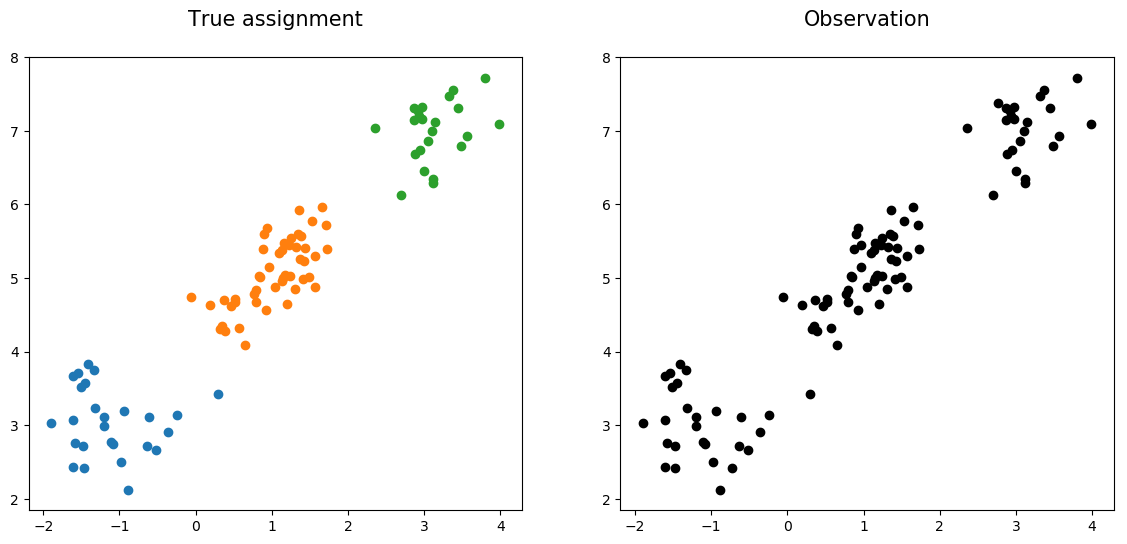

In [5]:
plt.figure(1, figsize=(14, 6), dpi=100)
plt.subplot(121)
plt.title('True assignment\n', fontsize=15)
for i in range(len(pi_true)):
    plt.plot(v[i, 1:C[i], 0], v[i, 1:C[i], 1], 'o')
    
plt.subplot(122)
plt.title('Observation\n', fontsize=15)
plt.plot(obs[:, 0], obs[:, 1], 'ko')

plt.show()

## 2. K-means

- K-means is special case in GMM
- Objective function
$$
J = \sum_{k=1}^K \sum_{i \in C_k} d(x_i, \mu_k)
$$

    - $x_n$: n번째 데이터 포인트 위치
    - $\mu_k$: k번째 중심의 위치를 나타내는 결정 변수
    - $r_{nk}$: n번째 데이터 포인트가 k번째 군집에 속하면 1, 그렇지 않으면 0인 이진 결정 변수

    > $J$의 최적 값을 구하는 과정에서 $r_{nk}$가 이진 결정 변수이므로 J를 $r_{nk}$에 대해 미분하는 것은 불가능합니다.<br/> 
    > 따라서 중심의 위치 $\mu_k$와 데이터의 할당 정보 $r_{nk}$를 상호적으로(Interacting) 변화시키면서 $J$의 값을 반복적으로 줄여나가는 반복 최적화(Iterative Optimization) 알고리즘으로 $\mu_k$값을 구할 수 있습니다.<br/> 
    > 이렇게 구한 $\mu_k$는 다음과 같이 나타납니다.

$J$를 $\mu_k$로 미분해줍니다. 그렇다면 $\mu_k$가 $r_{nk}$와 $x_n$에 대해서 local한 값을 가질수 있습니다.
    
$$
\mu_k=\frac{\sum_{n=1}^{N} x_n r_{nk}}{\sum_{n=1}^{N} r_{nk}}
$$

- Distance measure
$$
d(x_i, \mu_k) = || x_i - \mu_k ||^2
$$

- Iteration
    1. 임의의 중심값  $μ_k$  를 고른다. (보통 데이터 샘플 중의 하나를 선택)
    2. 중심에서 각 샘플 데이터까지의 거리를 계산
    3. 각 데이터 샘플에서 가장 가까운 중심을 선택하여 클러스터 갱신
    4. 다시 만들어진 클러스터에 대해 중심을 다시 계산하고 1 ~ 4를 반복한다.

__Distance Measure__

In [6]:
def distance(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

__k and iteration Setting__

In [10]:
k = 3 # 군집의 개수
itrEM = 100 # iteration 횟수
showVisualization = [2, 3, 4, 5, 6, 10, 20] # 군집화된 결과를 가시화 할 iteration 횟수

In [11]:
# iteration 에 따른 k-th cluster의 무계중심 (X,Y - 2차원)
centroid = np.zeros((itrEM, k, 2))
# objective function : Data point 와 centroid의 distance를 다 sumation 한 값
sumDistance = np.zeros(itrEM-1) 
# assignment : Nth data point가 속하는 군집 값
assignment = np.zeros(N, dtype = 'int64')

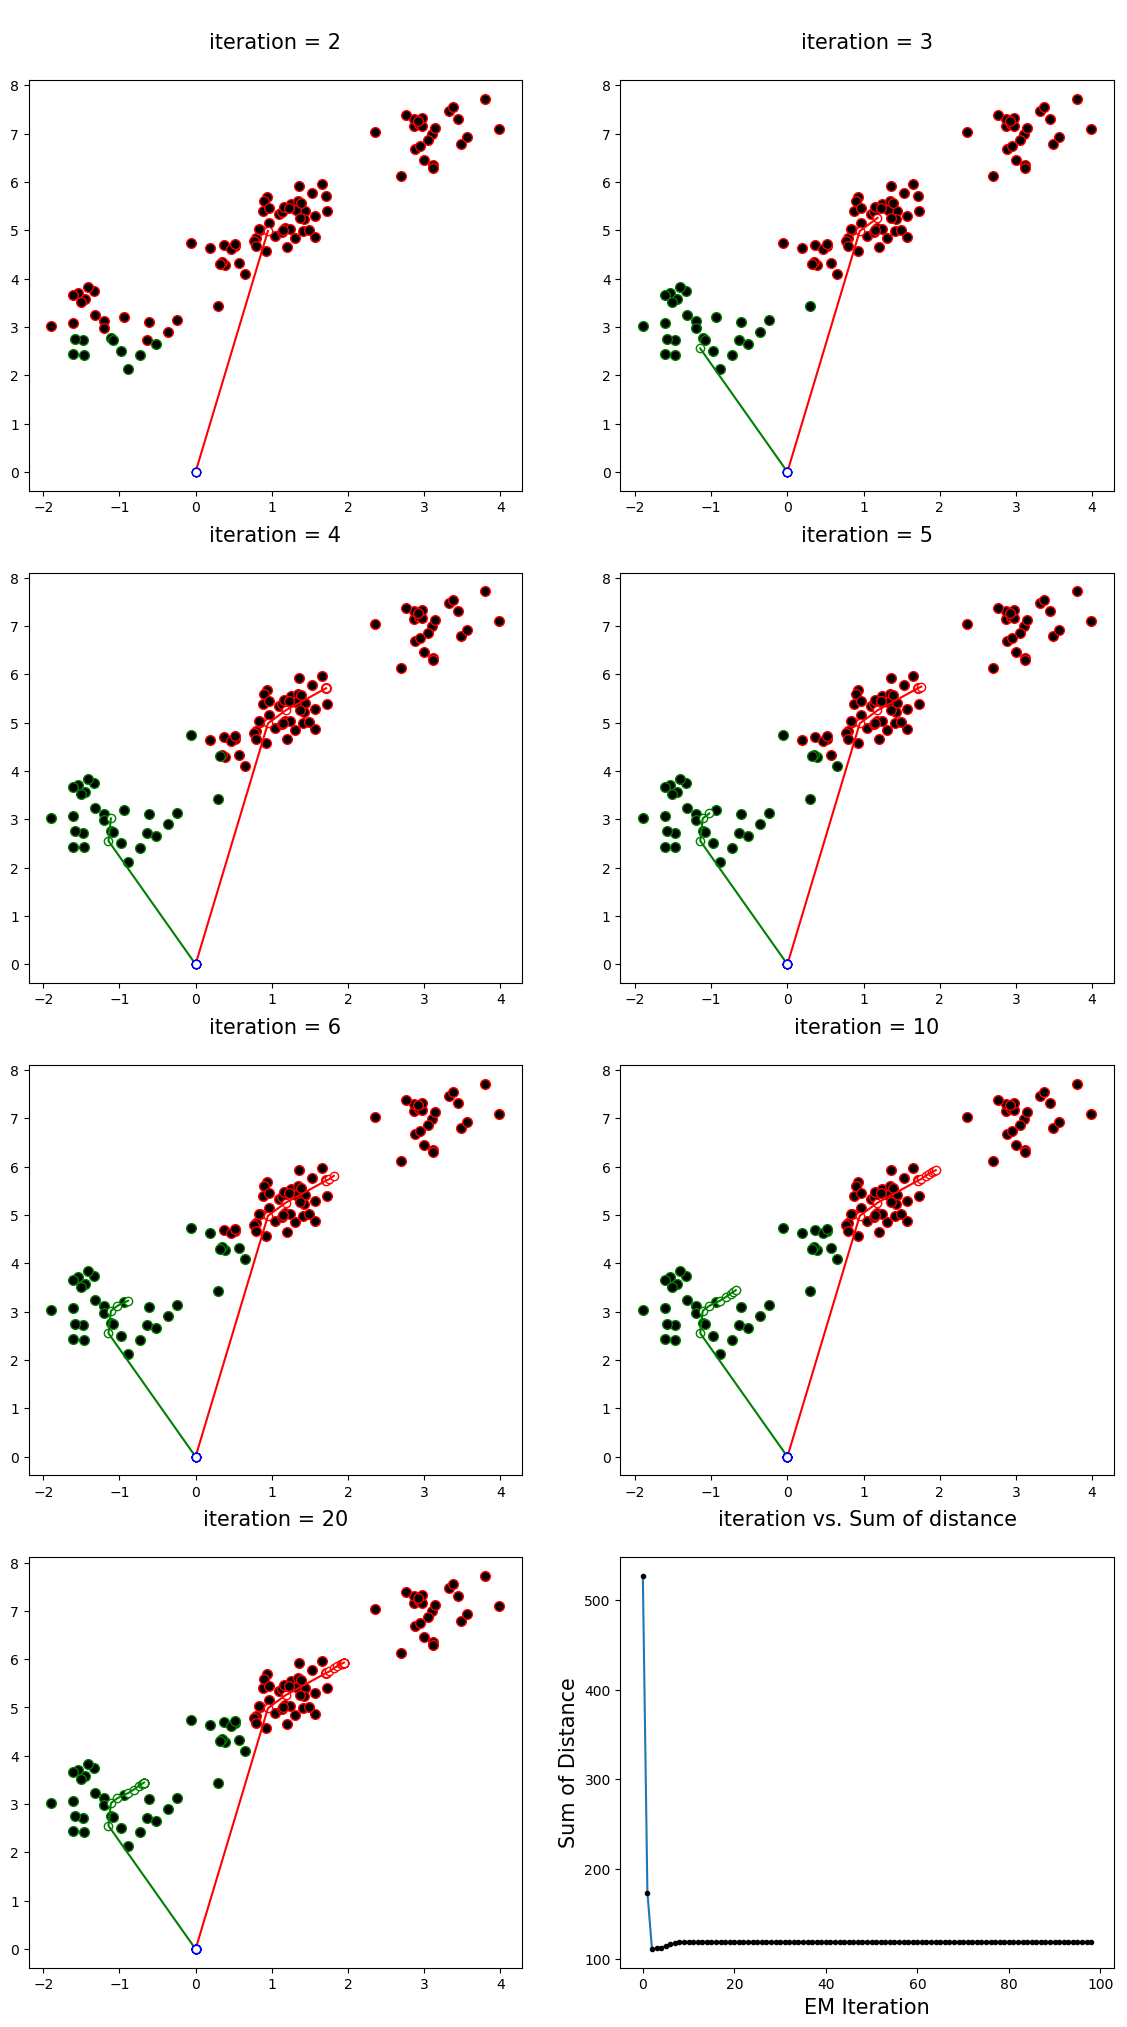

In [12]:
plt.figure(1, figsize=(14, 25), dpi=100)
plotN = 1
for i in range(1, itrEM):       
    for j in range(N): # 생성한 모든 random variable에 대하여 군집화를 실시
        idxK = 0
        minDist = distance(centroid[i-1, 0, :], obs[j, :]) # 첫번째 군집의 무게중심에 대한 데이터 포인트의 거리를 minDist의 초기값으로 설정
        
        #각 데이터 포인트를 가장 가까운 군집에 할당하는 과정 - EM알고리즘에서 E과정
        for l in range(1, k):
            dist = distance(centroid[i-1, l, :], obs[j, :]) # 각각의 무게중심에 대한 데이터 포인트의 거리 계산
            
            if minDist > dist: # 첫번째 군집보다 가까운 군집이 존재할 때, 데이터 포인트가 속하는 군집을 변경해 줌
                minDist = dist
                idxK = l
        assignment[j] = idxK
        sumDistance[i-1] += distance(centroid[i-1, idxK, :], obs[j, :]) # 목표함수 계산
    
    cntGroups = np.zeros(k) + 1e-5 # 해당 군집에 속하는 데이터 포인트가 0인 경우를 대비하여 1e-5를 더해줌
    
    for j in range(N):        
        cntGroups[assignment[j]] += 1 # 각 군집에 속하는 데이터 포인트 계산
        centroid[i, assignment[j]] += obs[j] # 각 군집에 속하는 데이터 포인트의 좌표값을 더해줌
    
    for j in range(k):
        centroid[i, j] /= cntGroups[j] # 각 군집의 무게중심 값 계산 - EM알고리즘에서 M과정
    
    if i in showVisualization: # 가시화 할 iterEM일 경우 아래의 과정을 수행함
        plt.subplot(4, 2, plotN)
        plt.title(' \niteration = %s\n'%(i), fontsize = 15)
        plotN += 1
        
        for j in range(k):
                  
            points = np.zeros((int(cntGroups[j]), 2))
            cntTemp = 0
            
            # 해당 데이터포인트가 j 군집에 속할 경우 points에 좌표를 저장함
            for l in range(N):
                if assignment[l] == j: 
                    points[cntTemp] = obs[l]
                    cntTemp += 1
            
            # j 군집에 속하는 point를 검정색 점으로 나타내고, 테두리는 col[j]로 나타냄
            plt.plot(points[:, 0], points[:, 1], 'ko', markeredgecolor = col[j], markersize = 7, markeredgewidth = 1) #검정
            # 초기 군집의 무게중심과 itrEM 후의 무게중심을 흰 점으로 나타내고 테두리는 col[j]로 나타냄
            plt.plot(centroid[0:i, j, 0], centroid[0:i, j, 1], 'wo', markeredgecolor = col[j])
            plt.plot(centroid[0:i, j, 0], centroid[0:i, j, 1], color = col[j])

# iteration에 따른 목표함수 값의 변화를 나타냄
plt.subplot(4, 2, 8)
plt.title('iteration vs. Sum of distance\n', fontsize=15)
plt.xlabel('EM Iteration', fontsize = 15)
plt.ylabel('Sum of Distance', fontsize = 15)
plt.plot(sumDistance[:])
plt.plot(sumDistance[:], 'ko', markersize = 3)

plt.show()

### Gaussian Mixture Model

K-means Clustering의 경우, 유클리드 거리가 적절하지 않은 경우, 그리고 하나의 데이터 포인트가 하나의 군집에 할당이 되지 않는 경우를 해결해 주기위하여 Soft Clustering 인 GMM을 학습해봅시다.

- Soft Clustering
$n$ 번째 데이터가 $k$ 번째 군집에 속해 있을 확률은 $\gamma(z_{nk})$ 라고 할때, 해당 클러스터에 등장할 확률을, 전체 클러스터에 등장할 확률로 나누어 주면 구할 수 있습니다.

$$\gamma(z_{nk}) = \frac{\pi_k N(x_n\space|\space\mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j N(x_n\space|\space\mu_j, \Sigma_j)}\color{red}{\space...\space eq\space(1)}
$$

- parameter의 경우, 편미분과 라그랑주 승수법을 활용하여 구할 수 있습니다.
<br>

$$
\hat{\mu_k} = \frac{\sum_{n=1}^{N} \gamma(z_{nk})x_n}{\sum_{n=1}^{N} \gamma(z_{nk})}\color{red}{\space...\space eq\space(2)}
$$
<br>

$$
\hat{\Sigma_k} = \frac{\sum_{n=1}^{N} \gamma(z_{nk})(x_n-\hat{\mu_k})(x_n-\hat{\mu_k})^T}{\sum_{n=1}^{N} \gamma(z_{nk})}\color{red}{\space...\space eq\space(3)}
$$
<br>

$$
\hat{\pi_k} = \frac{\sum_{n=1}^{N} \gamma(z_{nk})}{N}\color{red}{\space...\space eq\space(4)}
$$

- Log-Likelihood
EM알고리즘의 성능은 반복횟수에 따른 Log-likelihood값을 통해 확인가능 합니다. 이것은 일반적으로 density estimation이라고도 부르게 됩니다.
$$
L(\pi, \mu, \Sigma) = lnP(X=x\space|\space\pi, \mu, \Sigma) = \sum_{n=1}^{N}ln\space(\sum_{k=1}^{K}\pi_k N(x_n\space|\space\mu_k,\Sigma_k))\color{red}{\space...\space eq\space(5)}
$$

$$
l(\theta) = \sum_{m}\log{p(x^{i}|\theta)} = \sum_{n}\log{\sum_{z^{i}}p(x^{i},z^{i}|\theta)} \\
= \sum_{m}log\sum_{z^{i}}Q(z^{i})\frac{p(x^{i},z^{i})}{}
$$

In [13]:
k = 3
itrEM = 100
showVisualization = [1, 2, 4, 8, 16, 32, 99]

In [14]:
mu = np.zeros((itrEM, k, 2))
sigma = np.zeros((itrEM, k, 2, 2))
pi = np.zeros((itrEM, k))
likelihood = np.zeros(itrEM-1) # 로그우도값
assignment = np.zeros((N, k)) # n번째 데이터가 k번째 군집에 속해 있을 확률값

In [15]:
for i in range(k):
    mu[0,i] = obs[i]
    sigma[0,i] = np.eye(2)
    pi[0,i]= 1.0/k

initalization

In [16]:
mu[0]

array([[2.8635176 , 7.15436714],
       [3.48674032, 6.79439979],
       [3.11940844, 6.34716723]])

In [17]:
sigma[0]

array([[[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]],

       [[1., 0.],
        [0., 1.]]])

In [18]:
pi[0]

array([0.33333333, 0.33333333, 0.33333333])

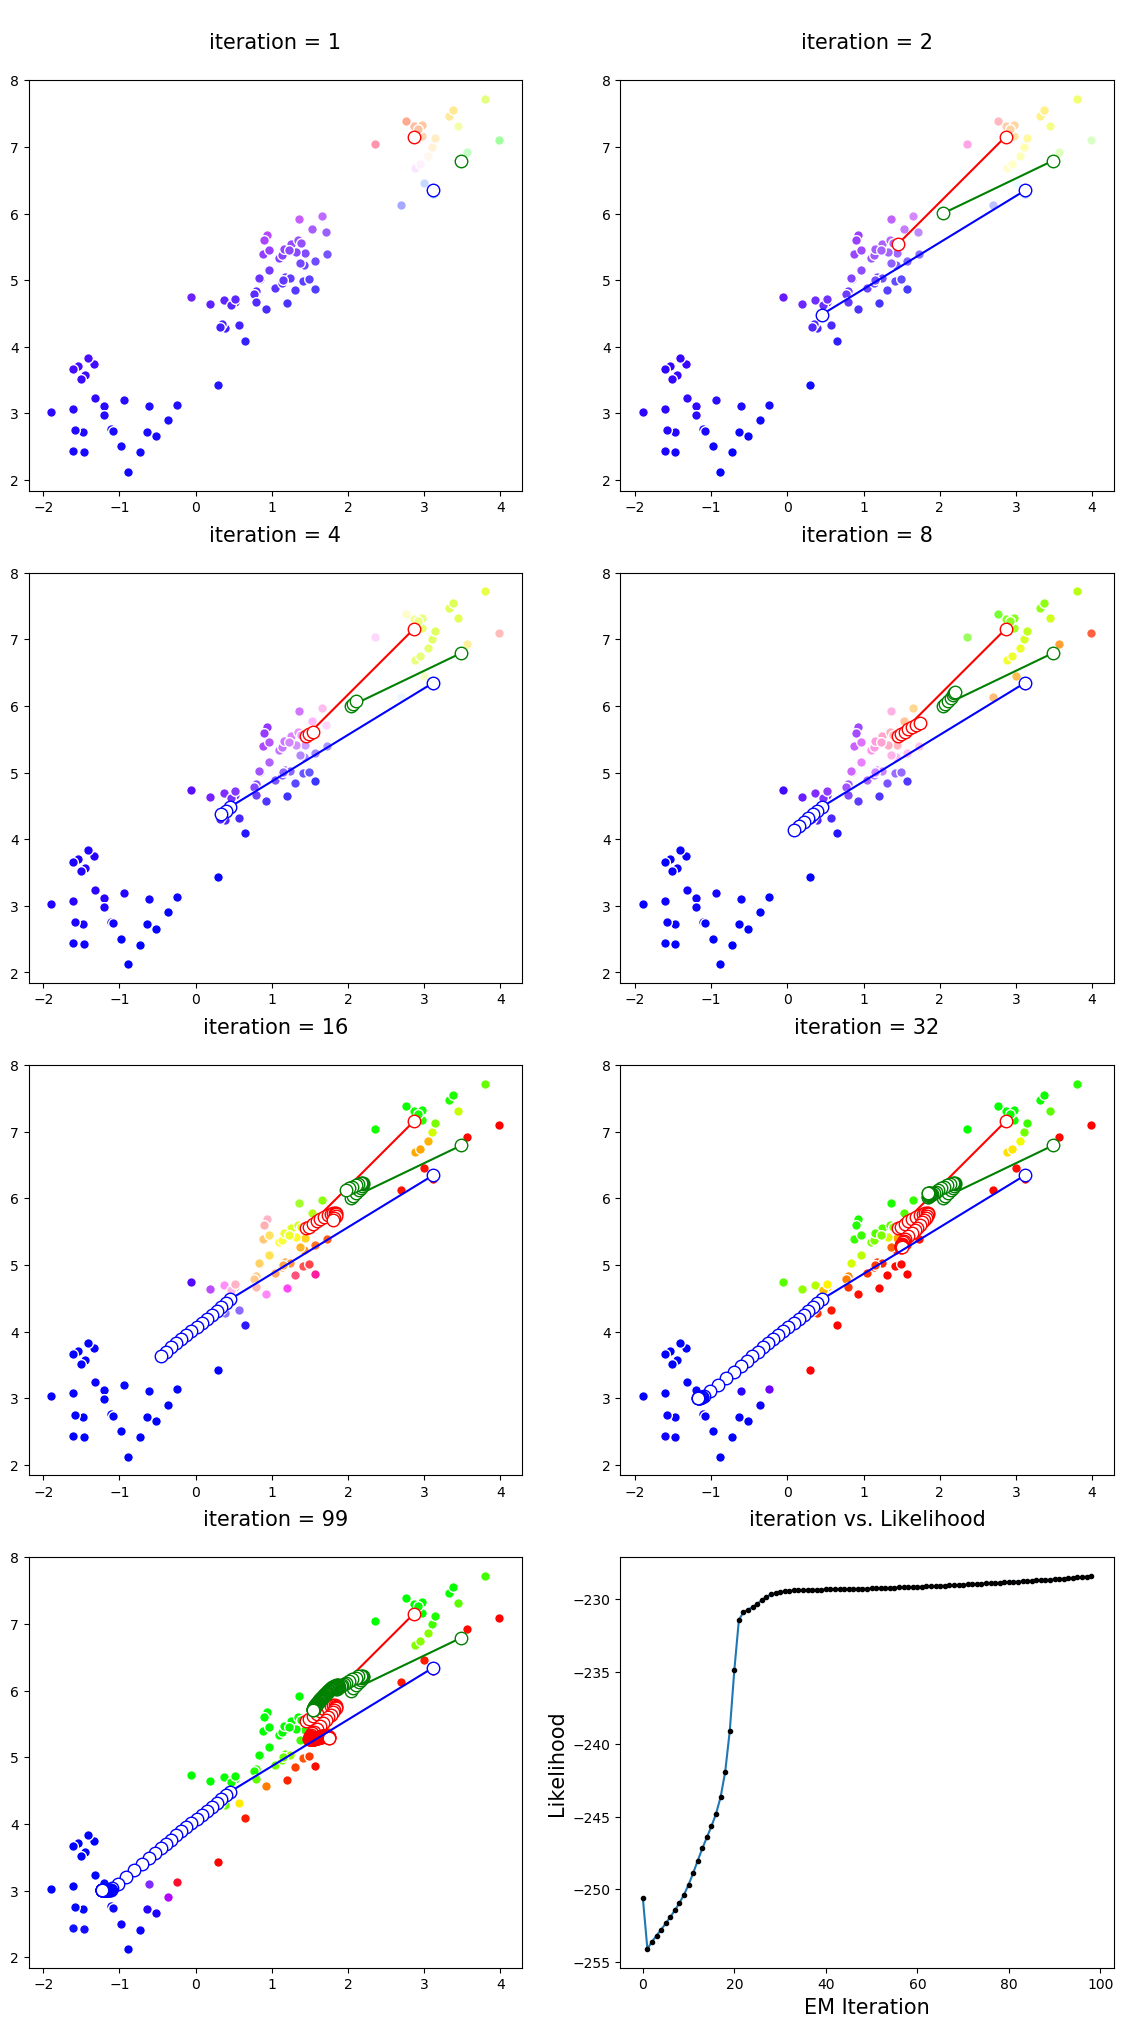

In [20]:
plt.figure(1, figsize=(14, 25), dpi=100)
plotN = 1
for i in range(1, itrEM):
    
    # EM알고리즘 기댓값(E) 과정...eq(1)
    for j in range(N):
        for l in range(k):
            assignment[j, l] = pi[i-1, l] * multivariate_normal.pdf(obs[j, :], mu[i-1, l], sigma[i-1, l])
            
        assignment[j] /= np.sum(assignment[j])
    
    # EM알고리즘의 최대화(M) 과정
    ## mu의 최우추정값을 구하는 과정...eq(2)
    for j in range(k):
        normalize = 0
        mu[i, j] = np.zeros((1,2))
        
        for l in range(N):
            mu[i,j] += assignment[l, j] * obs[l]
            normalize +=  assignment[l, j]
        
        mu[i, j] /= normalize
    
    ## Sigma의 최우추정값을 구하는 과정...eq(3)
    for j in range(k):
        normalize = 0
        sigma[i, j] = np.zeros((2,2))
        
        for l in range(N):
            sigma[i, j] += assignment[l, j] * np.multiply(np.transpose([obs[l] - mu[i, j]]), obs[l] - mu[i, j])
            normalize += assignment[l, j]
            
        sigma[i, j] /= normalize
    
    ## pi의 최우추정값을 구하는 과정...eq(4)
    for j in range(k):
        for l in range(N):
            pi[i, j] += assignment[l, j]
            
        pi[i, j] /= N
        
    ## 로그 우도값(log liklihood)의 계산...eq(5)
    likelihood[i-1] = 0
    for j in range(N):        
        sumL = 0
        
        for l in range(k):
            sumL += pi[i, l] * multivariate_normal.pdf(obs[j], mu[i, l], sigma[i, l])
        
        likelihood[i-1] += np.log(sumL)
        
    if i in showVisualization:
        plt.subplot(4, 2, plotN)
        plt.title(' \niteration = %s\n'%(i), fontsize=15)
        plotN += 1
        
        for j in range(N):
            assignment[j] /= np.max(assignment[j])
            # 각 군집에 속할 확률로 weighted된 색으로 데이터 포인트를 나타냄
            plt.plot(obs[j, 0], obs[j, 1], 'o', markersize = 7, 
                     markerfacecolor = (assignment[j, 0], assignment[j, 1], assignment[j, 2]), markeredgecolor = 'w')
        
        for j in range(k):
            points = np.zeros((i, 2))
            
            for l in range(i):
                points[l] = mu[l, j]
            # iteration마다 이동하는 다변수 가우스 분포의 평균값 벡터를 나타냄
            plt.plot(points[:, 0], points[:, 1], color = col[j])
            plt.plot(points[:, 0], points[:, 1], 'wo', markeredgecolor = col[j], markersize = 9, markeredgewidth = 1)

# iteration에 따른 로그우도값을 나타냄          
plt.subplot(4, 2, 8)
plt.title('iteration vs. Likelihood\n', fontsize=15)
plt.xlabel('EM Iteration', fontsize = 15)
plt.ylabel('Likelihood', fontsize = 15)
plt.plot(likelihood[:])
plt.plot(likelihood[:], 'ko', markersize = 3)


plt.show()